# Deep Learning
## Practice Projects
# P2: Multi-Label Classification

## Step 0. Style and Libraries
Let's choose a style of the Jupyter notebook and import the software libraries. The command hide_code will hide the code cells.

In [2]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                  

In [35]:
hide_code = ''
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

In [4]:
hide_code
# Plot the Neural network fitting history
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['acc'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_acc'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

## Step 1. Load and Explore the Data
For this project, I have created the dataset of 1650 (50x33) color images (32x32x3) with 33 handwritten letters.


Run the following cell to download the dataset.

In [6]:
hide_code
# Function for processing an image
def image_to_tensor(img_path):
    img = keras_image.load_img("data/" + img_path, target_size=(32, 32))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True 
# Load the data
data = pd.read_csv("data/letters.csv")
files = data['file']
letters = data['letter']
backgrounds = data['background']
targets = data['label'].values
tensors = data_to_tensor(files);

100%|██████████| 1650/1650 [00:18<00:00, 91.16it/s] 


In [7]:
hide_code
# Print the shape 
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (1650, 32, 32, 3)
Target shape (1650,)


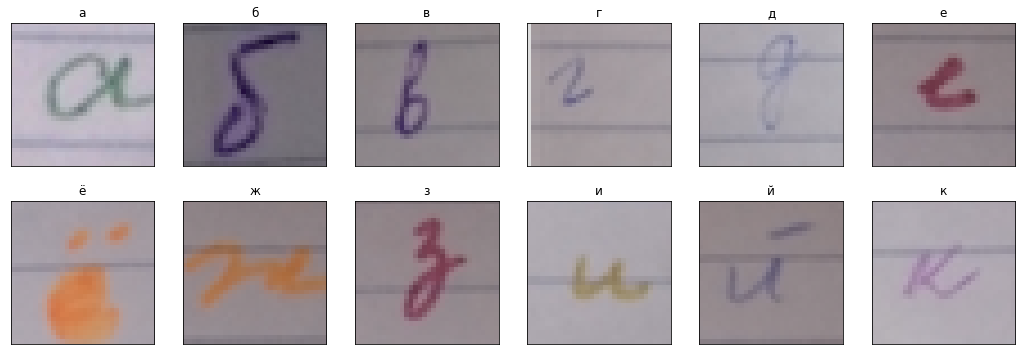

In [8]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i*50])
    display_images(files[i*50], ax)

## Step 2. Save and Load the Data
The data tensors can be saved in the appropriate format of files .h5.

In [9]:
hide_code
# Create the tensor file
with h5py.File('LetterColorImages.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.create_dataset('backgrounds', data = backgrounds)
    f.close()

In [10]:
hide_code
# Read the h5 file
f = h5py.File('LetterColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['backgrounds', 'images', 'labels']

In [11]:
hide_code
# Create tensors and targets
tensors = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (1650, 32, 32, 3)
Target shape (1650,)


## Step 3. Implement Preprocess Functions
### Normalize and Gray Scale
In the cell below, normalize the image tensors, and return them as a normalized Numpy array.

In [12]:
hide_code
# Normalize the tensors
tensors = tensors.astype('float32')/255

Label:  в


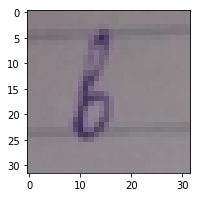

In [13]:
hide_code
# Read and display a tensor using Matplotlib
print('Label: ', letters[100])
plt.figure(figsize=(3,3))
plt.imshow(tensors[100]);

Create tensors of grayscaled images and display their shape.

In [14]:
hide_code
# Grayscaled tensors
gray_tensors = np.dot(tensors[...,:3], [0.299, 0.587, 0.114])
print ('Grayscaled Tensor shape:', gray_tensors.shape)

Grayscaled Tensor shape: (1650, 32, 32)


Label:  в


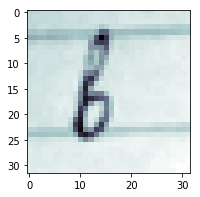

In [15]:
hide_code
# Read and display a grayscaled tensor using Matplotlib
print('Label: ', letters[100])
plt.figure(figsize=(3,3))
plt.imshow(gray_tensors[100], cmap=cm.bone);

### One-hot encode
Now we'll implement the one-hot encoding function to_categorical.

In [16]:
hide_code
# Print the target unique values
print(set(targets))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [17]:
hide_code
# One-hot encode the targets, started from the zero label
cat_targets = to_categorical(np.array(targets-1), 33)
cat_targets.shape

(1650, 33)

In [18]:
hide_code
# One-hot encode the background targets
backgrounds = to_categorical(backgrounds, 2)
backgrounds.shape

(1650, 2)

### Add background

In [19]:
hide_code
# Create multi-label targets
back_targets = np.concatenate((cat_targets, backgrounds), axis=1)
back_targets.shape

(1650, 35)

### Split
#### Color Images
Apply the function train_test_split and split the data into training and testing sets. 

Set up the size for the test set - 10% and for the validation set - 10%.

In [20]:
hide_code
# Split the data
x_train, x_test, y_train, y_test = train_test_split(tensors, cat_targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [21]:
hide_code
# Print the shape
x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape

((1320, 32, 32, 3),
 (165, 32, 32, 3),
 (165, 32, 32, 3),
 (1320, 33),
 (165, 33),
 (165, 33))

#### Grayscaled Images

In [24]:
hide_code
# Split the grayscaled data
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_tensors, cat_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]

In [25]:
hide_code
# Reshape the grayscaled data
x_train2, x_test2, x_valid2 = \
x_train2.reshape(-1, 32, 32, 1), x_test2.reshape(-1, 32, 32, 1), x_valid2.reshape(-1, 32, 32, 1)

In [26]:
hide_code
# Print the shape
x_train2.shape, x_valid2.shape, x_test2.shape, y_train2.shape, y_valid2.shape, y_test2.shape

((1320, 32, 32, 1),
 (165, 32, 32, 1),
 (165, 32, 32, 1),
 (1320, 33),
 (165, 33),
 (165, 33))

In [27]:
# Convert images from grayscaled to RGB
x_train2_tensor = tf.image.grayscale_to_rgb(x_train2, name=None)
x_test2_tensor = tf.image.grayscale_to_rgb(x_test2, name=None)
x_valid2_tensor = tf.image.grayscale_to_rgb(x_valid2, name=None)
# Run tensorflow session
sess = tf.Session()
with sess.as_default():
    x_train2_color = x_train2_tensor.eval()
    x_test2_color = x_test2_tensor.eval()
    x_valid2_color = x_valid2_tensor.eval()
# Check the shape    
x_train2_color.shape, x_test2_color.shape, x_valid2_color.shape

((1320, 32, 32, 3), (165, 32, 32, 3), (165, 32, 32, 3))

#### Multi-label targets, color images

In [28]:
hide_code
# Split with multi-label targets
x_train3, x_test3, y_train3, y_test3 = train_test_split(tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
x_valid3, y_valid3 = x_test3[:n], y_test3[:n]
x_test3, y_test3 = x_test3[n:], y_test3[n:]

In [29]:
hide_code
# Print the shape
x_train3.shape, x_valid3.shape, x_test3.shape, y_train3.shape, y_valid3.shape, y_test3.shape

((1320, 32, 32, 3),
 (165, 32, 32, 3),
 (165, 32, 32, 3),
 (1320, 35),
 (165, 35),
 (165, 35))

In [30]:
hide_code
# Create a list of targets
y_train3_list = [y_train3[:, :33], y_train3[:, 33:]]
y_test3_list = [y_test3[:, :33], y_valid3[:, 33:]]
y_valid3_list = [y_valid3[:, :33], y_valid3[:, 33:]]

#### Multi-label targets, grayscaled images

In [91]:
hide_code
# Split the grayscaled data
x_train4, x_test4, y_train4, y_test4 = train_test_split(gray_tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
x_valid4, y_valid4 = x_test4[:n], y_test4[:n]
x_test4, y_test4 = x_test4[n:], y_test4[n:]

In [92]:
hide_code
# Reshape the grayscaled data
x_train4, x_test4, x_valid4 = \
x_train4.reshape(-1, 32, 32, 1), x_test4.reshape(-1, 32, 32, 1), x_valid4.reshape(-1, 32, 32, 1)

In [93]:
hide_code
# Print the shape
x_train4.shape, x_valid4.shape, x_test4.shape, y_train4.shape, y_valid4.shape, y_test4.shape

((1320, 32, 32, 1),
 (165, 32, 32, 1),
 (165, 32, 32, 1),
 (1320, 35),
 (165, 35),
 (165, 35))

In [94]:
hide_code
# Create a list of targets
y_train4_list = [y_train4[:, :33], y_train4[:, 33:]]
y_test4_list = [y_test4[:, :33], y_test4[:, 33:]]
y_valid4_list = [y_valid4[:, :33], y_valid4[:, 33:]]

## Step 4. Create a One-Label Classification Model
### Color Images
Define a model architecture and compile the model for color images.

In [41]:
hide_code
def model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(33))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model()

In [42]:
hide_code
# Create callbacks
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.2)

In [43]:
hide_code
# Train the model
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=64, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, lr_reduction])

Train on 1320 samples, validate on 165 samples
Epoch 1/100
 - 10s - loss: 3.5201 - acc: 0.0227 - val_loss: 3.4983 - val_acc: 0.0485

Epoch 00001: val_loss improved from inf to 3.49834, saving model to weights.best.model.hdf5
Epoch 2/100
 - 8s - loss: 3.4917 - acc: 0.0508 - val_loss: 3.4904 - val_acc: 0.0424

Epoch 00002: val_loss improved from 3.49834 to 3.49045, saving model to weights.best.model.hdf5
Epoch 3/100
 - 8s - loss: 3.4649 - acc: 0.0462 - val_loss: 3.4723 - val_acc: 0.0424

Epoch 00003: val_loss improved from 3.49045 to 3.47232, saving model to weights.best.model.hdf5
Epoch 4/100
 - 7s - loss: 3.4662 - acc: 0.0530 - val_loss: 3.4712 - val_acc: 0.0424

Epoch 00004: val_loss improved from 3.47232 to 3.47119, saving model to weights.best.model.hdf5
Epoch 5/100
 - 7s - loss: 3.4512 - acc: 0.0402 - val_loss: 3.4717 - val_acc: 0.0606

Epoch 00005: val_loss did not improve from 3.47119
Epoch 6/100
 - 8s - loss: 3.4468 - acc: 0.0508 - val_loss: 3.4657 - val_acc: 0.0606

Epoch 00006

 - 8s - loss: 3.0794 - acc: 0.1197 - val_loss: 3.2367 - val_acc: 0.1030

Epoch 00050: val_loss improved from 3.24761 to 3.23672, saving model to weights.best.model.hdf5
Epoch 51/100
 - 9s - loss: 3.0709 - acc: 0.1318 - val_loss: 3.2365 - val_acc: 0.1152

Epoch 00051: val_loss improved from 3.23672 to 3.23647, saving model to weights.best.model.hdf5
Epoch 52/100
 - 9s - loss: 3.0574 - acc: 0.1348 - val_loss: 3.2403 - val_acc: 0.1152

Epoch 00052: val_loss did not improve from 3.23647
Epoch 53/100
 - 9s - loss: 3.0523 - acc: 0.1197 - val_loss: 3.2325 - val_acc: 0.0909

Epoch 00053: val_loss improved from 3.23647 to 3.23253, saving model to weights.best.model.hdf5
Epoch 54/100
 - 8s - loss: 3.0538 - acc: 0.1280 - val_loss: 3.2384 - val_acc: 0.1212

Epoch 00054: val_loss did not improve from 3.23253
Epoch 55/100
 - 8s - loss: 3.0487 - acc: 0.1205 - val_loss: 3.2269 - val_acc: 0.1091

Epoch 00055: val_loss improved from 3.23253 to 3.22688, saving model to weights.best.model.hdf5
Epoch 56/10


Epoch 00098: val_loss improved from 3.00910 to 2.98458, saving model to weights.best.model.hdf5
Epoch 99/100
 - 9s - loss: 2.6906 - acc: 0.2265 - val_loss: 2.9615 - val_acc: 0.1455

Epoch 00099: val_loss improved from 2.98458 to 2.96147, saving model to weights.best.model.hdf5
Epoch 100/100
 - 9s - loss: 2.6769 - acc: 0.2273 - val_loss: 2.9679 - val_acc: 0.1697

Epoch 00100: val_loss did not improve from 2.96147


We should have an accuracy greater than 3%

In [44]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

165/165 [==============================] - 0s 3ms/step


[2.9150874094529584, 0.15757575757575756]

Apply the ImageDataGenerator() function.

In [45]:
hide_code
# Fit the model with ImageDataGenerator()
steps, epochs = 1000, 5
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

generator = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),
                                steps_per_epoch = steps, epochs = epochs,
                                validation_data = (x_valid, y_valid), 
                                callbacks=[checkpointer, lr_reduction], verbose=2)

Epoch 1/5
 - 452s - loss: 2.5762 - acc: 0.2427 - val_loss: 2.6819 - val_acc: 0.2242

Epoch 00001: val_loss improved from 2.96147 to 2.68193, saving model to weights.best.model.hdf5
Epoch 2/5
 - 461s - loss: 2.2461 - acc: 0.3352 - val_loss: 2.4237 - val_acc: 0.2909

Epoch 00002: val_loss improved from 2.68193 to 2.42368, saving model to weights.best.model.hdf5
Epoch 3/5
 - 418s - loss: 1.9200 - acc: 0.4279 - val_loss: 2.0991 - val_acc: 0.3758

Epoch 00003: val_loss improved from 2.42368 to 2.09913, saving model to weights.best.model.hdf5
Epoch 4/5
 - 425s - loss: 1.6372 - acc: 0.5038 - val_loss: 1.9231 - val_acc: 0.4242

Epoch 00004: val_loss improved from 2.09913 to 1.92313, saving model to weights.best.model.hdf5
Epoch 5/5
 - 380s - loss: 1.4137 - acc: 0.5626 - val_loss: 1.7656 - val_acc: 0.4303

Epoch 00005: val_loss improved from 1.92313 to 1.76556, saving model to weights.best.model.hdf5


In [46]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

165/165 [==============================] - 0s 2ms/step


[1.6711222280155529, 0.4666666668472868]

Let's compare the results with classifying algorithms.

In [47]:
hide_code
# Fit the classifier and get the accuracy score
y_train_c = np.array([np.argmax(y) for y in y_train])
y_test_c = np.array([np.argmax(y) for y in y_test])
clf = GradientBoostingClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf.score(x_test.reshape(-1, 32*32*3), y_test_c)

0.10303030303030303

In [48]:
hide_code
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf2.score(x_test.reshape(-1, 32*32*3), y_test_c)

0.09090909090909091

### Grayscaled Images

In [95]:
hide_code
def gray_model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train2.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02)) 
    model.add(Dropout(0.25)) 
    
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.02)) 
    model.add(Dropout(0.25))    

    model.add(Dense(33))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

gray_model = gray_model()

In [64]:
hide_code
# Create callbacks
gray_checkpointer = ModelCheckpoint(filepath='weights.best.gray_model.hdf5', 
                                    verbose=2, save_best_only=True)
gray_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=10, verbose=2, factor=0.8)

In [65]:
hide_code
# Train the model
gray_history = gray_model.fit(x_train2, y_train2, 
                              epochs=200, batch_size=64, verbose=0,
                              validation_data=(x_valid2, y_valid2),
                              callbacks=[gray_checkpointer, gray_lr_reduction])


Epoch 00001: val_loss improved from inf to 3.49760, saving model to weights.best.gray_model.hdf5

Epoch 00002: val_loss did not improve from 3.49760

Epoch 00003: val_loss did not improve from 3.49760

Epoch 00004: val_loss did not improve from 3.49760

Epoch 00005: val_loss did not improve from 3.49760

Epoch 00006: val_loss improved from 3.49760 to 3.49566, saving model to weights.best.gray_model.hdf5

Epoch 00007: val_loss improved from 3.49566 to 3.49229, saving model to weights.best.gray_model.hdf5

Epoch 00008: val_loss did not improve from 3.49229

Epoch 00009: val_loss improved from 3.49229 to 3.48260, saving model to weights.best.gray_model.hdf5

Epoch 00010: val_loss improved from 3.48260 to 3.47657, saving model to weights.best.gray_model.hdf5

Epoch 00011: val_loss improved from 3.47657 to 3.45542, saving model to weights.best.gray_model.hdf5

Epoch 00012: val_loss did not improve from 3.45542

Epoch 00013: val_loss did not improve from 3.45542

Epoch 00014: val_loss impro


Epoch 00119: val_loss did not improve from 1.50671

Epoch 00120: val_loss did not improve from 1.50671

Epoch 00121: val_loss did not improve from 1.50671

Epoch 00122: val_loss did not improve from 1.50671

Epoch 00123: val_loss did not improve from 1.50671

Epoch 00124: val_loss improved from 1.50671 to 1.43768, saving model to weights.best.gray_model.hdf5

Epoch 00125: val_loss did not improve from 1.43768

Epoch 00126: val_loss did not improve from 1.43768

Epoch 00127: val_loss did not improve from 1.43768

Epoch 00128: val_loss did not improve from 1.43768

Epoch 00129: val_loss did not improve from 1.43768

Epoch 00130: val_loss did not improve from 1.43768

Epoch 00131: val_loss did not improve from 1.43768

Epoch 00132: val_loss improved from 1.43768 to 1.41228, saving model to weights.best.gray_model.hdf5

Epoch 00133: val_loss did not improve from 1.41228

Epoch 00134: val_loss did not improve from 1.41228

Epoch 00135: val_loss improved from 1.41228 to 1.34279, saving mode

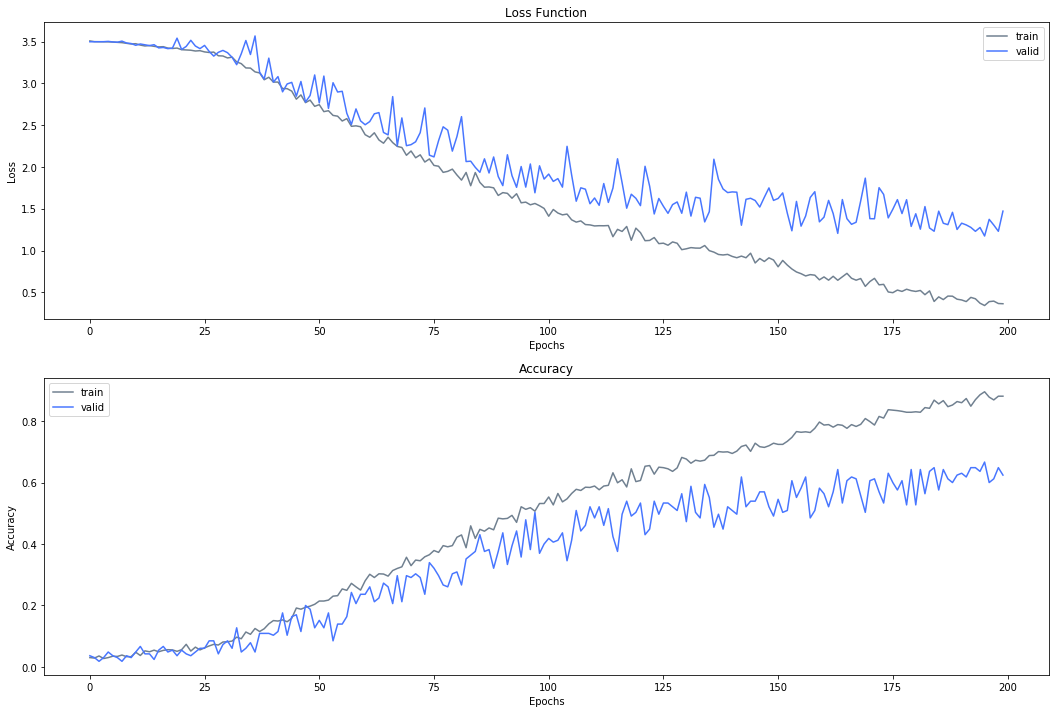

In [66]:
hide_code
# Plot the training history
history_plot(gray_history, 0)

Try to reach an accuracy greater than 50%

In [67]:
hide_code
# Load the model with the best validation accuracy
gray_model.load_weights('weights.best.gray_model.hdf5')
# Calculate classification accuracy on the testing set
gray_score = gray_model.evaluate(x_test2, y_test2)
gray_score

165/165 [==============================] - 0s 1ms/step


[1.081701368635351, 0.6909090912703312]

Apply the ImageDataGenerator() function.

In [68]:
hide_code
# Fit the model with ImageDataGenerator()
steps, epochs = 1000, 10
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

gray_generator = gray_model.fit_generator(data_generator.flow(x_train2, y_train2, batch_size=64),
                                          steps_per_epoch = steps, epochs = epochs,
                                          validation_data = (x_valid2, y_valid2), 
                                          callbacks=[gray_checkpointer, gray_lr_reduction], verbose=2)

Epoch 1/10
 - 265s - loss: 1.2616 - acc: 0.6257 - val_loss: 1.1346 - val_acc: 0.6485

Epoch 00001: val_loss improved from 1.17393 to 1.13462, saving model to weights.best.gray_model.hdf5
Epoch 2/10
 - 276s - loss: 1.0199 - acc: 0.6866 - val_loss: 0.9844 - val_acc: 0.7091

Epoch 00002: val_loss improved from 1.13462 to 0.98438, saving model to weights.best.gray_model.hdf5
Epoch 3/10
 - 257s - loss: 0.8821 - acc: 0.7256 - val_loss: 0.9625 - val_acc: 0.7030

Epoch 00003: val_loss improved from 0.98438 to 0.96252, saving model to weights.best.gray_model.hdf5
Epoch 4/10
 - 278s - loss: 0.7678 - acc: 0.7588 - val_loss: 0.9479 - val_acc: 0.7273

Epoch 00004: val_loss improved from 0.96252 to 0.94789, saving model to weights.best.gray_model.hdf5
Epoch 5/10
 - 292s - loss: 0.6857 - acc: 0.7822 - val_loss: 1.0155 - val_acc: 0.7212

Epoch 00005: val_loss did not improve from 0.94789
Epoch 6/10
 - 275s - loss: 0.6113 - acc: 0.8052 - val_loss: 0.8892 - val_acc: 0.7333

Epoch 00006: val_loss improve

In [69]:
hide_code
# Load the model with the best validation accuracy
gray_model.load_weights('weights.best.gray_model.hdf5')
# Calculate classification accuracy on the testing set
gray_score = gray_model.evaluate(x_test2, y_test2)
gray_score

165/165 [==============================] - 0s 1ms/step


[0.6657397743427392, 0.7878787882400281]

Let's compare the results with classifying algorithms.

In [80]:
hide_code
# Fit the classifier and get the accuracy score
y_train2_c = np.array([np.argmax(y) for y in y_train2])
y_test2_c = np.array([np.argmax(y) for y in y_test2])
clf = GradientBoostingClassifier().fit(x_train2.reshape(-1, 32*32), y_train2_c)
clf.score(x_test2.reshape(-1, 32*32), y_test2_c)

0.081818181818181818

In [81]:
hide_code
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train2.reshape(-1, 32*32), y_train2_c)
clf2.score(x_test2.reshape(-1, 32*32), y_test2_c)

0.087878787878787876

## Step 5. Create a Multi-Label Classification Model
### Color Images

In [ ]:
hide_code
def multi_model():    
    model_input = Input(shape=(32, 32, 3))
    x = BatchNormalization()(model_input)
    
    # TODO: Define a model architecture
    x = Conv2D(32, (3, 3), padding='same')(model_input)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.25)(x)
    
    x = Dense(128)(x)  
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.25)(x)
    
    y1 = Dense(33, activation='softmax')(x)
    y2 = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2])
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

multi_model = multi_model()

In [ ]:
hide_code
# Display the model architecture
multi_model.summary()

In [ ]:
hide_code
# Create callbacks
multi_checkpointer = ModelCheckpoint(filepath='weights.best.multi.hdf5', 
                                     verbose=2, save_best_only=True)
multi_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                       patience=5, verbose=2, factor=0.8)

In [ ]:
hide_code
# Train the model
multi_history = multi_model.fit(x_train3, y_train3_list, 
                                validation_data=(x_valid3, y_valid3_list), 
                                epochs=100, batch_size=64, verbose=0, 
                                callbacks=[multi_checkpointer, multi_lr_reduction])

We should have an accuracy greater than 3% for the first target (letter) and greater than 50% for the second target (background).

In [ ]:
hide_code
# Load the model with the best validation accuracy
multi_model.load_weights('weights.best.multi.hdf5')
# Calculate classification accuracy on the testing set
multi_scores = multi_model.evaluate(x_test3, y_test3_list, verbose=0)

print("Scores: \n" , (multi_scores))
print("First label. Accuracy: %.2f%%" % (multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (multi_scores[4]*100))

### Grayscaled Images

In [107]:
hide_code
def gray_multi_model():    
    model_input = Input(shape=(32, 32, 1))
    x = BatchNormalization()(model_input)
    
    # TODO: Define a model architecture
    x = Conv2D(32, (5, 5), padding='same')(model_input)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.25)(x)
    
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.25)(x)
    
    y1 = Dense(33, activation='softmax')(x)
    y2 = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2])
    
    # TODO: Compile the model    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

gray_multi_model = gray_multi_model()

In [108]:
hide_code
# Display the model architecture
gray_multi_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 32, 32, 32)   832         input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_45 (LeakyReLU)      (None, 32, 32, 32)   0           conv2d_35[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_35 (MaxPooling2D) (None, 16, 16, 32)   0           leaky_re_lu_45[0][0]             
__________________________________________________________________________________________________
dropout_65

In [109]:
hide_code
# Create callbacks
gray_multi_checkpointer = ModelCheckpoint(filepath='weights.best.gray_multi.hdf5', 
                                          verbose=2, save_best_only=True)
hide_code
# Display the model architecture
gray_multi_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=10, verbose=2, factor=0.8)

In [110]:
hide_code
# Train the model
gray_multi_history = gray_multi_model.fit(x_train4, y_train4_list, 
                                          validation_data=(x_valid4, y_valid4_list), 
                                          epochs=100, batch_size=64, verbose=0, 
                                          callbacks=[gray_multi_checkpointer, gray_multi_lr_reduction])


Epoch 00001: val_loss improved from inf to 4.19105, saving model to weights.best.gray_multi.hdf5

Epoch 00002: val_loss improved from 4.19105 to 4.18717, saving model to weights.best.gray_multi.hdf5

Epoch 00003: val_loss did not improve from 4.18717

Epoch 00004: val_loss did not improve from 4.18717

Epoch 00005: val_loss improved from 4.18717 to 4.18072, saving model to weights.best.gray_multi.hdf5

Epoch 00006: val_loss did not improve from 4.18072

Epoch 00007: val_loss improved from 4.18072 to 4.18071, saving model to weights.best.gray_multi.hdf5

Epoch 00008: val_loss improved from 4.18071 to 4.16065, saving model to weights.best.gray_multi.hdf5

Epoch 00009: val_loss did not improve from 4.16065

Epoch 00010: val_loss improved from 4.16065 to 4.11665, saving model to weights.best.gray_multi.hdf5

Epoch 00011: val_loss improved from 4.11665 to 4.10661, saving model to weights.best.gray_multi.hdf5

Epoch 00012: val_loss improved from 4.10661 to 4.10513, saving model to weights.b

We should have an accuracy greater than 3% for the first target (letter) and greater than 50% for the second target (background).

In [111]:
hide_code
# Load the model with the best validation accuracy
gray_multi_model.load_weights('weights.best.gray_multi.hdf5')
# Calculate classification accuracy on the testing set
gray_multi_scores = gray_multi_model.evaluate(x_test4, y_test4_list, verbose=0)

print("Scores: \n" , (gray_multi_scores))
print("First label. Accuracy: %.2f%%" % (gray_multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (gray_multi_scores[4]*100))

Scores: 
 [3.863917894074411, 3.276771663896965, 0.5871462684689146, 0.11515151515151516, 0.7636363639976039]
First label. Accuracy: 11.52%
Second label. Accuracy: 76.36%


## Step 6. Keras Applications
Choose one of the keras applications and try to reach an accuracy greater than 30%
### Color Images

In [33]:
hide_code
# Create bottleneck features
resize_x_train = np.array([scipy.misc.imresize(x_train[i], (139, 139, 3)) 
                           for i in range(0, len(x_train))]).astype('float32')
resize_x_valid = np.array([scipy.misc.imresize(x_valid[i], (139, 139, 3)) 
                           for i in range(0, len(x_valid))]).astype('float32')
resize_x_test = np.array([scipy.misc.imresize(x_test[i], (139, 139, 3)) 
                          for i in range(0, len(x_test))]).astype('float32')

iv3_x_train = preprocess_input(resize_x_train)
iv3_x_valid = preprocess_input(resize_x_valid)
iv3_x_test = preprocess_input(resize_x_test)

iv3_base_model = InceptionV3(weights='imagenet', include_top=False)
x_train_bn = iv3_base_model.predict(iv3_x_train)
x_valid_bn = iv3_base_model.predict(iv3_x_valid)
x_test_bn = iv3_base_model.predict(iv3_x_test)

In [34]:
hide_code
# Save bottleneck features
x_train_bn = np.squeeze(x_train_bn)
x_valid_bn = np.squeeze(x_valid_bn)
x_test_bn = np.squeeze(x_test_bn)

np.save('x_train_bn.npy', x_train_bn)
np.save('x_valid_bn.npy', x_valid_bn)
np.save('x_test_bn.npy', x_test_bn)

In [35]:
hide_code
# Load bottleneck features
x_train_bn = np.load('x_train_bn.npy')
x_valid_bn = np.load('x_valid_bn.npy')
x_test_bn = np.load('x_test_bn.npy')

In [270]:
hide_code
def iv3_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(filters=32, kernel_size=2, input_shape=x_train_bn.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(33, activation='softmax'))
    # TODO: Compile the model     
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

iv3_model = iv3_model()

In [ ]:
hide_code
# Create callbacks
iv3_checkpointer = ModelCheckpoint(filepath='weights.best.iv3.hdf5', 
                                     verbose=2, save_best_only=True)

In [271]:
hide_code
# Fit the model 
iv3_history = iv3_model.fit(x_train_bn, y_train, 
                            validation_data=(x_valid_bn, y_valid),
                            epochs=50, batch_size=64, 
                            callbacks=[iv3_checkpointer], verbose=0);

Epoch 00000: val_loss improved from inf to 3.67129, saving model to weights.best.iv3.hdf5
Epoch 00001: val_loss improved from 3.67129 to 3.21915, saving model to weights.best.iv3.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 3.21915 to 2.83821, saving model to weights.best.iv3.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 2.83821 to 2.81490, saving model to weights.best.iv3.hdf5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 2.81490 to 2.80183, saving model to weights.best.iv3.hdf5
Epoch 00009: val_loss improved from 2.80183 to 2.73322, saving model to weights.best.iv3.hdf5
Epoch 00010: val_loss improved from 2.73322 to 2.40326, saving model to weights.best.iv3.hdf5
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoc

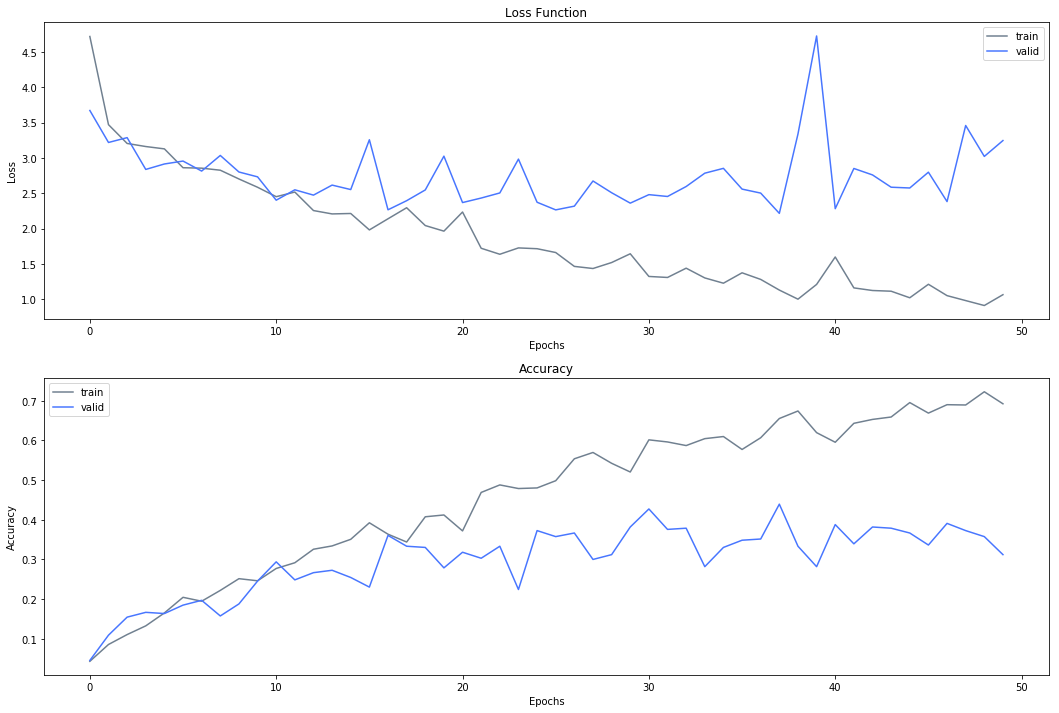

In [272]:
hide_code
# Plot the training history
history_plot(iv3_history, 0)

In [273]:
hide_code
# Load the model with the best validation accuracy
iv3_model.load_weights('weights.best.iv3.hdf5')
# Calculate classification accuracy on the testing set
iv3_scores = iv3_model.evaluate(x_test_bn, y_test)
print("Accuracy: %.2f%%" % (iv3_scores[1]*100))
iv3_scores

320/330 [============================>.] - ETA: 0sAccuracy: 43.94%


[2.2173518325343275, 0.43939393903269913]

### Grayscaled Images

In [226]:
hide_code
# Create bottleneck features
resize_x_train2 = np.array([scipy.misc.imresize(x_train2_color[i], (139, 139, 3)) 
                            for i in range(0, len(x_train2_color))]).astype('float32')
resize_x_valid2 = np.array([scipy.misc.imresize(x_valid2_color[i], (139, 139, 3)) 
                            for i in range(0, len(x_valid2_color))]).astype('float32')
resize_x_test2 = np.array([scipy.misc.imresize(x_test2_color[i], (139, 139, 3)) 
                           for i in range(0, len(x_test2_color))]).astype('float32')

iv3_x_train2 = preprocess_input(resize_x_train2)
iv3_x_valid2 = preprocess_input(resize_x_valid2)
iv3_x_test2 = preprocess_input(resize_x_test2)

iv3_base_model2 = InceptionV3(weights='imagenet', include_top=False)
x_train_bn2 = iv3_base_model2.predict(iv3_x_train2)
x_valid_bn2 = iv3_base_model2.predict(iv3_x_valid2)
x_test_bn2 = iv3_base_model2.predict(iv3_x_test2)

In [227]:
hide_code
# Save bottleneck features
x_train_bn2 = np.squeeze(x_train_bn2)
x_valid_bn2 = np.squeeze(x_valid_bn2)
x_test_bn2 = np.squeeze(x_test_bn2)

np.save('x_train_bn2.npy', x_train_bn2)
np.save('x_valid_bn2.npy', x_valid_bn2)
np.save('x_test_bn2.npy', x_test_bn2)

In [228]:
hide_code
# Load bottleneck features
x_train_bn2 = np.load('x_train_bn2.npy')
x_valid_bn2 = np.load('x_valid_bn2.npy')
x_test_bn2 = np.load('x_test_bn2.npy')

In [262]:
hide_code
def iv3_gray_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(filters=32, kernel_size=2, input_shape=x_train_bn2.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(33, activation='softmax'))
    # TODO: Compile the model     
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

iv3_gray_model = iv3_gray_model()

In [ ]:
hide_code
# Create callbacks
iv3_gray_checkpointer = ModelCheckpoint(filepath='weights.best.iv3_gray.hdf5', 
                                        verbose=2, save_best_only=True)

In [263]:
hide_code
# Fit the model 
iv3_gray_history = iv3_gray_model.fit(x_train_bn2, y_train2, 
                                      validation_data=(x_valid_bn2, y_valid2),
                                      epochs=50, batch_size=64, 
                                      callbacks=[iv3_gray_checkpointer], verbose=0);

Epoch 00000: val_loss improved from inf to 3.45489, saving model to weights.best.iv3_gray.hdf5
Epoch 00001: val_loss improved from 3.45489 to 3.25901, saving model to weights.best.iv3_gray.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 3.25901 to 2.95905, saving model to weights.best.iv3_gray.hdf5
Epoch 00004: val_loss improved from 2.95905 to 2.77506, saving model to weights.best.iv3_gray.hdf5
Epoch 00005: val_loss improved from 2.77506 to 2.69466, saving model to weights.best.iv3_gray.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 2.69466 to 2.52928, saving model to weights.best.iv3_gray.hdf5
Epoch 00008: val_loss improved from 2.52928 to 2.47701, saving model to weights.best.iv3_gray.hdf5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 2.47701 to 2.45250, saving model to weights.best.iv3_gray.hdf5
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 2.45250 to 2.43977, savi

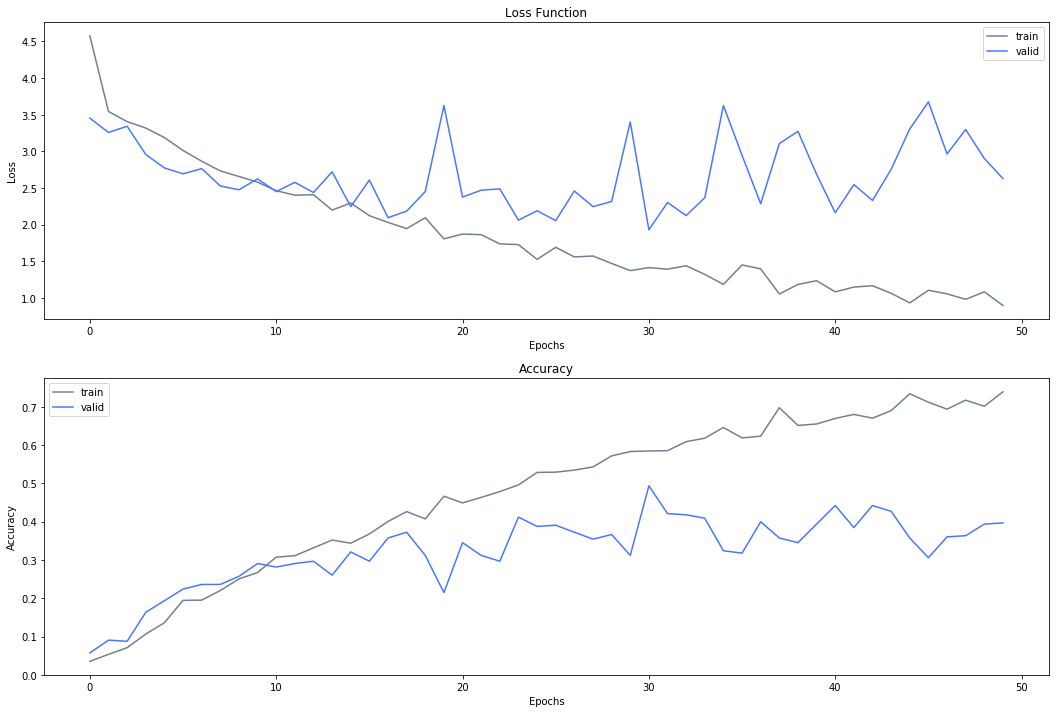

In [264]:
hide_code
# Plot the training history
history_plot(iv3_gray_history, 0)

In [265]:
hide_code
# Load the model with the best validation accuracy
iv3_gray_model.load_weights('weights.best.iv3_gray.hdf5')
# Calculate classification accuracy on the testing set
iv3_gray_scores = iv3_gray_model.evaluate(x_test_bn2, y_test2)
print("Accuracy: %.2f%%" % (iv3_gray_scores[1]*100))
iv3_gray_scores

256/330 [======================>.......] - ETA: 0sAccuracy: 49.39%


[1.930430860230417, 0.49393939412001409]

## Step 7. Predictions
Display predictions for the models with the best accuracy.
### Color Images

In [39]:
hide_code
# Create a list of symbols
symbols = ['а','б','в','г','д','е','ё','ж','з','и','й',
           'к','л','м','н','о','п','р','с','т','у','ф',
           'х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я']

In [286]:
hide_code
# Model predictions for the testing dataset
y_test_predict = iv3_model.predict_classes(x_test_bn)

288/330 [=========================>....] - ETA: 0s

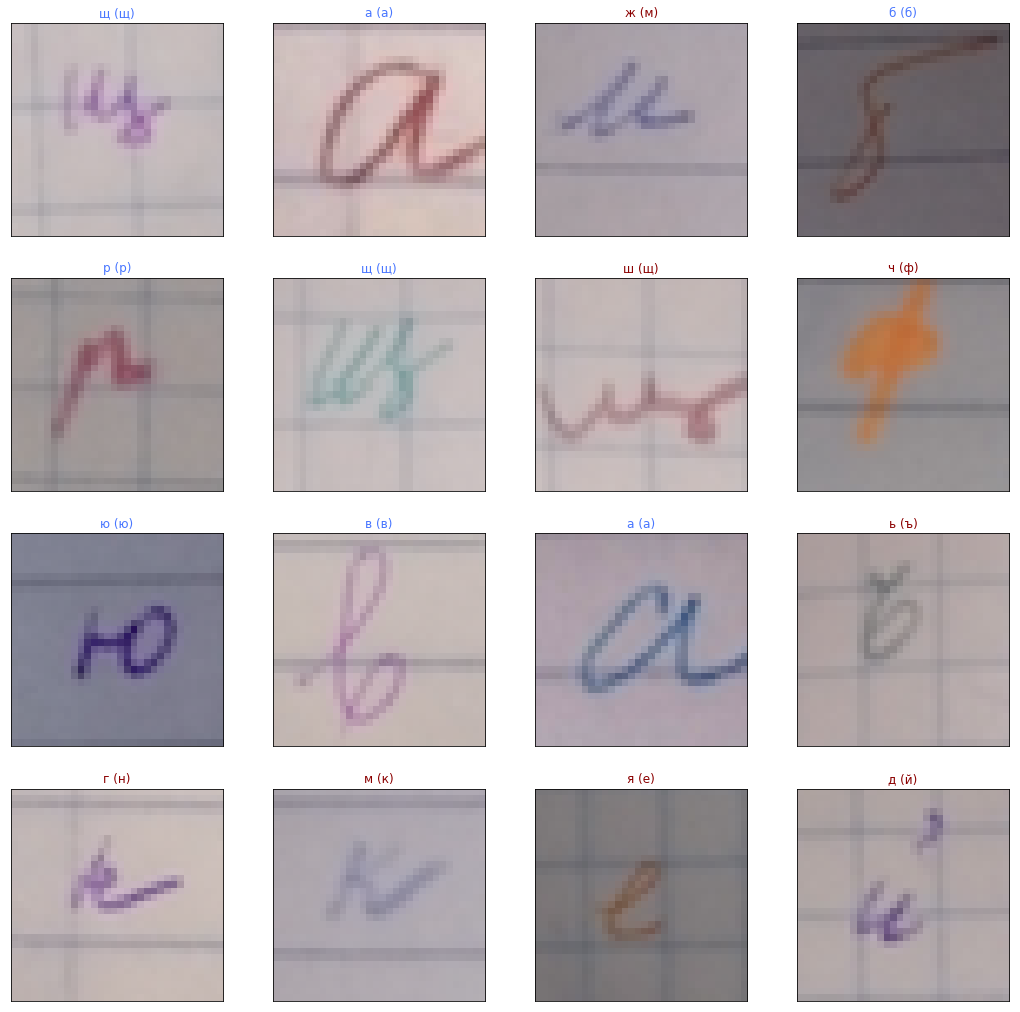

In [287]:
hide_code
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))

### Grayscaled Images

In [37]:
hide_code
# Model predictions for the testing dataset
y_test2_predict = gray_model.predict_classes(x_test2)

320/330 [============================>.] - ETA: 0s

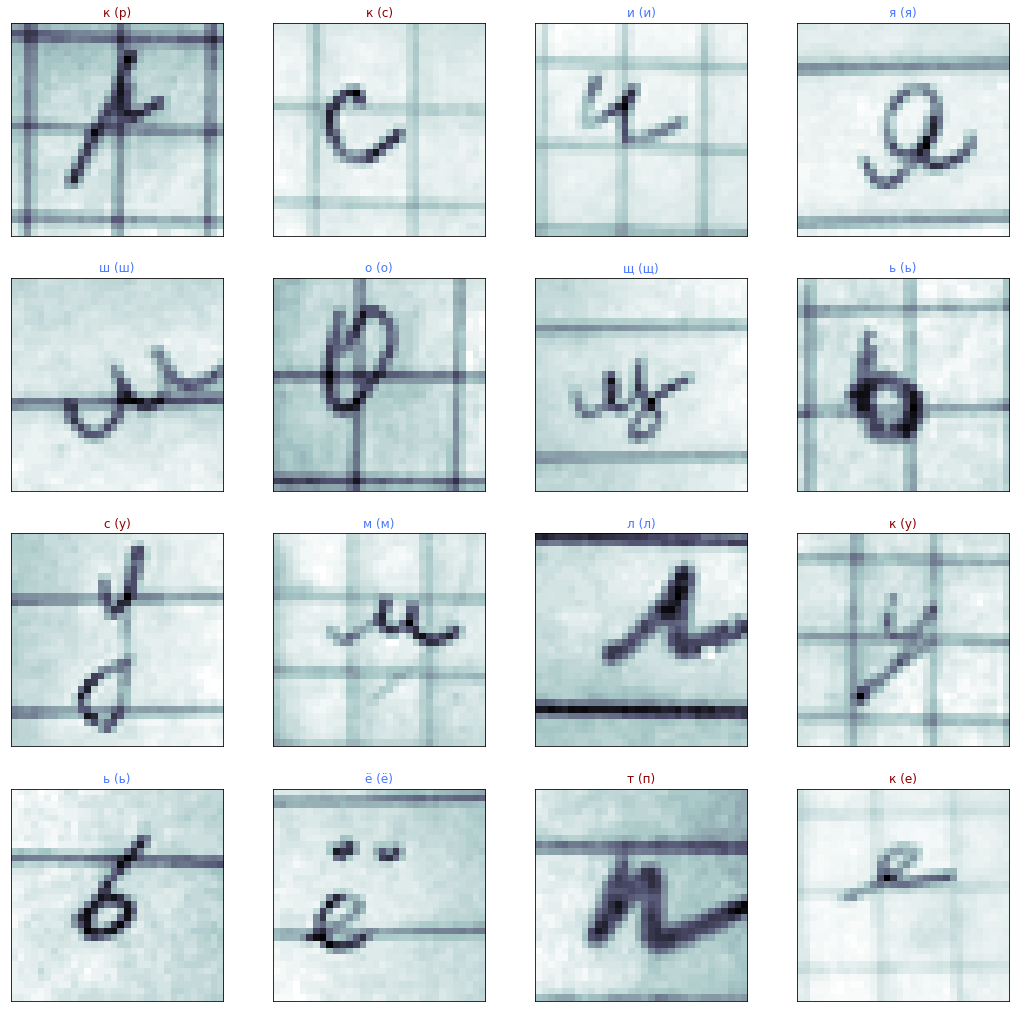

In [41]:
hide_code
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test2.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test2[idx]), cmap=cm.bone)
    pred_idx = y_test2_predict[idx]
    true_idx = np.argmax(y_test2[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))